In [1]:
%matplotlib inline
from matplotlib.pyplot import imshow
from PIL import Image
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import random
random.seed(42)
import numpy as np
np.random.seed(42)
import cv2
import time

import keras
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import decode_predictions
from keras.models import Sequential, Model, load_model
from keras.regularizers import l2
from keras.layers import Input, Activation, Concatenate
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import Lambda, Add
from keras import optimizers
from keras.utils.generic_utils import CustomObjectScope

from losses import *
from focal_loss import *

from loaddata import loadData
import train

Using TensorFlow backend.


In [2]:
data, labels, images = loadData(train.targetShape, keras.applications.resnet50.preprocess_input)
print data.shape, labels.shape

nSamples 5904
nItems 652935168 nPos 0.00144696165714 nNeg 0.998553038343
(5904, 192, 192, 3) (5904, 192, 192, 2)


In [3]:
dataInit = data
labelsInit = labels
imagesInit = images

lowerBound = 64# validation images in real
data   = dataInit  [-lowerBound:]
labels = labelsInit[-lowerBound:]
images = imagesInit[-lowerBound:]

# upperBound = 20# validation images in real
# data   = dataInit  [:upperBound]
# labels = labelsInit[:upperBound]
# images = imagesInit[:upperBound]

print data.shape

(64, 192, 192, 3)


In [4]:
# modelName = "dump/model.h5"
modelName = "dump/checkpoint.h5"
print 'reading...', modelName
#modelName = "dump/model_bak.h5"
with CustomObjectScope({
    'relu6': keras.applications.mobilenet.relu6,
    'DepthwiseConv2D': keras.applications.mobilenet.DepthwiseConv2D,
    'f' : weightedBinaryCrossentropy([1, 1])}):
    model = load_model(modelName)
    inp = model.inputs[0]
    out = model.outputs[-1]
    model = Model(inputs=[inp], outputs=[out])
print 'Readed!'

reading... dump/checkpoint.h5
Readed!


In [5]:
startTime = time.time()
predicted = model.predict(data)
print 'Prediction elapsed', time.time() - startTime

Prediction elapsed 12.6084580421


In [6]:
print np.min(predicted), '-', np.max(predicted)
# predicted[predicted > 0.004] = 1

2.33552e-05 - 0.965272


7.61664e-05 - 0.836017


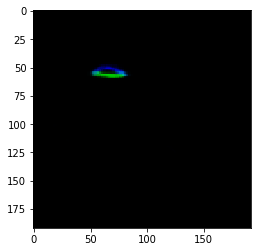

In [7]:
index2Show = 15
lbl = predicted[index2Show, :, :]
toShow = np.zeros(images[0].shape, dtype=lbl.dtype)
toShow[:, :, 2] = lbl[:, :, 0]
toShow[:, :, 1] = lbl[:, :, 1]
# toShow *= 2
print np.min(lbl), '-', np.max(lbl)
imshow(toShow, cmap='gray')

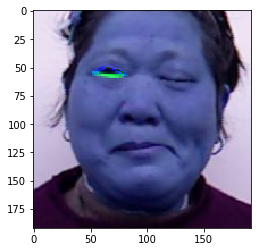

In [8]:
toShowComposed = images[index2Show].astype(np.float32) / 255.0 + toShow
toShowComposed[toShowComposed > 255] = 255
toShowComposed[toShowComposed < 0] = 0
imshow(toShowComposed)

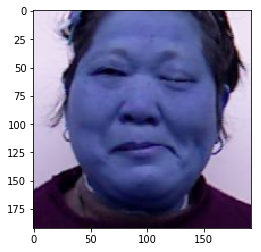

In [9]:
imshow(images[index2Show])

## 